# Program za določitev višine kapljevinskega stolpca

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL.Image as Image
import pyautogui

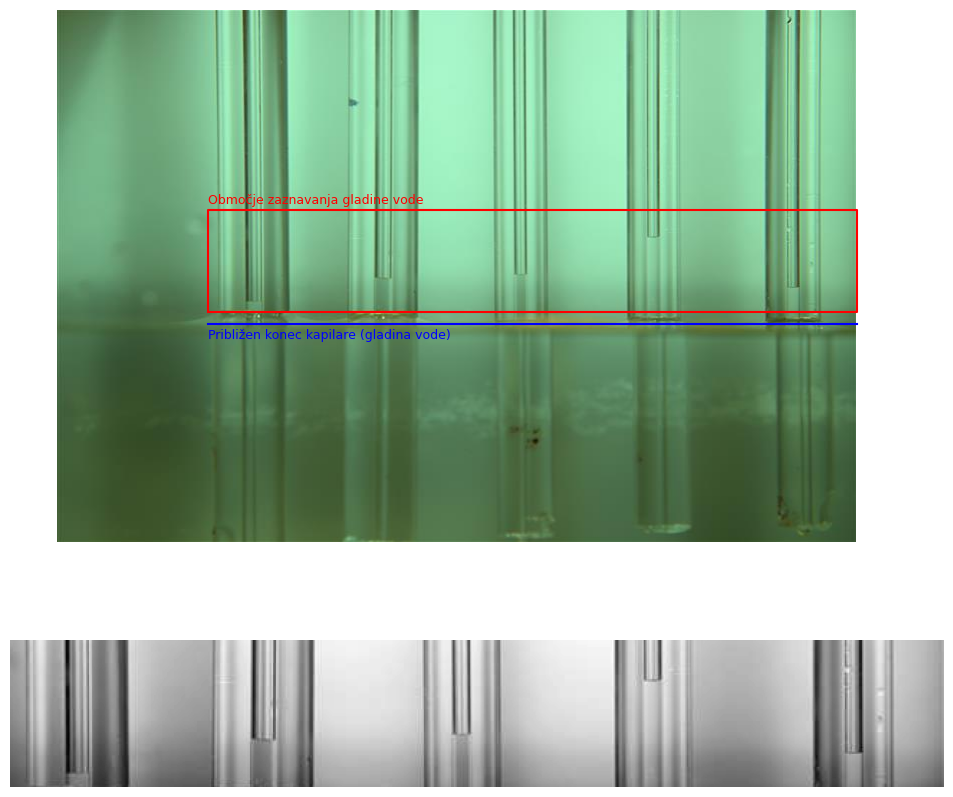

In [2]:
img_or = cv2.cvtColor(cv2.imread(r"SK2_23-10-2025.JPG"), cv2.COLOR_BGR2GRAY)
img_rgb = cv2.cvtColor(cv2.imread(r"SK2_23-10-2025.JPG"), cv2.COLOR_BGR2RGB)
canal_diam = 8 #mm
heigth_plus = 12 #px

x_left = 150
x_right = 800
y_top = 200
y_bottom = 302
img = img_or[y_top:y_bottom, x_left:x_right]
img_h, img_w = img.shape
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(img_rgb)
plt.text(x_left, y_top - 6, "Območje zaznavanja gladine vode", fontsize=9, color="red")
plt.plot([x_left, x_right, x_right, x_left, x_left], [y_bottom, y_bottom, y_top, y_top, y_bottom], c="red")
plt.text(x_left, y_bottom + heigth_plus + 15, "Približen konec kapilare (gladina vode)", fontsize=9, color="blue")
plt.plot([x_left, x_right], [y_bottom + heigth_plus, y_bottom + heigth_plus], c="blue")
plt.axis("off")
plt.subplot(2,1,2)
plt.imshow(img, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

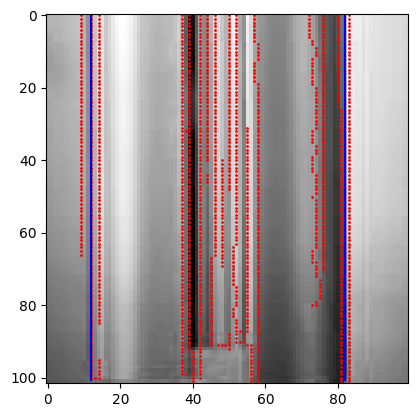

Meassured diameter in px: 69.934,
mm/px ratio: 0.114


In [3]:
sobel_x = cv2.Sobel(img[:,:100], cv2.CV_64F, dx=1, dy=0, ksize=1)
sobel_x = cv2.convertScaleAbs(sobel_x)
edges_x = cv2.Canny(sobel_x, 50 , 80)
y_coords, x_coords = np.where(edges_x > 0)
edge_points = np.column_stack((x_coords, y_coords))
edge_points = edge_points[edge_points[:, 0].argsort()] #sort by x

grouped_points = []
current_group = []
range_width = 20 #Group points range

if len(edge_points) > 0:
    current_group.append(edge_points[0])
    group_start_x = edge_points[0][0]

    for point in edge_points[1:]:
        x, y = point
        if x - group_start_x <= range_width:
            current_group.append(point)
        else:
            grouped_points.append(current_group)
            current_group = [point]
            group_start_x = x

    grouped_points.append(current_group)


start = np.mean(np.array(grouped_points[0])[:, 0])
end = np.mean(np.array(grouped_points[-1])[:, 0])
d_px = end - start

plt.imshow(img[:,:100], cmap="gray")
plt.vlines([start, end], [0,0],[img_h-1, img_h-1], colors="blue")
plt.scatter(x_coords, y_coords, color="red", s=1)
plt.show()


mm_px_ratio = canal_diam/d_px


print(f"Meassured diameter in px: {np.round(d_px, 3)},")
print(f"mm/px ratio: {np.round(mm_px_ratio, 3)}")

Group 1: 16 points, X px range ~ 39-45
Group 2: 16 points, X px range ~ 168-185
Group 3: 18 points, X px range ~ 307-320
Group 4: 30 points, X px range ~ 441-453
Group 5: 18 points, X px range ~ 584-592


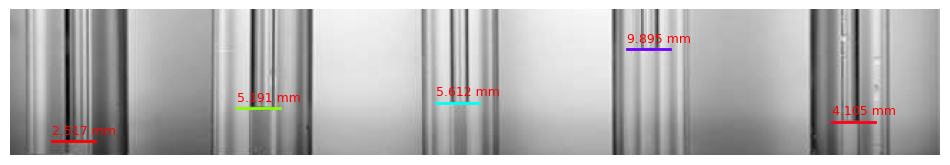

Heigth for group 1 in px: 22.0 px
Heigth for group 2 in px: 45.375 px
Heigth for group 3 in px: 49.056 px
Heigth for group 4 in px: 86.5 px
Heigth for group 5 in px: 35.889 px
#------------------------------------#
Heigth for group 1 in mm: 2.517 mm
Heigth for group 2 in mm: 5.191 mm
Heigth for group 3 in mm: 5.612 mm
Heigth for group 4 in mm: 9.895 mm
Heigth for group 5 in mm: 4.105 mm


In [4]:
sobel_y = cv2.Sobel(img, cv2.CV_64F, dx=0, dy=1, ksize=1)
sobel_y = cv2.convertScaleAbs(sobel_y)
edges = cv2.Canny(sobel_y, 80 , 190)

y_coords, x_coords = np.where(edges > 0)
edge_points = np.column_stack((x_coords, y_coords))
edge_points = edge_points[edge_points[:, 0].argsort()] #sort by x

grouped_points = []
current_group = []
range_width = 30 #Group points range

if len(edge_points) > 0:
    current_group.append(edge_points[0])
    group_start_x = edge_points[0][0]

    for point in edge_points[1:]:
        x, y = point
        if x - group_start_x <= range_width:
            current_group.append(point)
        else:
            grouped_points.append(current_group)
            current_group = [point]
            group_start_x = x

    grouped_points.append(current_group)

for i, group in enumerate(grouped_points):
    print(f"Group {i+1}: {len(group)} points, X px range ~ {group[0][0]}-{group[-1][0]}")


plt.figure(figsize=(12, 6))
plt.imshow(img, cmap="gray")

colors = plt.get_cmap('hsv', len(grouped_points))
line_length = 30  

y_group_px = {}
y_group_mm = {}
for i, group in enumerate(grouped_points):
    group = np.array(group)
    x_vals = group[:, 0]
    y_vals = group[:, 1]

    x_start = x_vals.min() - 10
    x_end = x_start + line_length
    y_mean = np.mean(y_vals)
    y_mean_1 = (img_h - np.mean(y_vals)) + heigth_plus
    y_group_px.update({i : y_mean_1})
    y_group_mm.update({i : y_mean_1 * mm_px_ratio})
    plt.text(x_start, y_mean - 5, f"{np.round(y_mean_1 * mm_px_ratio, 3)} mm", fontsize=9, color="red")
    plt.plot([x_start, x_end], [y_mean, y_mean], color=colors(i), linewidth=2)

plt.axis("off")
plt.show()

for i, group in enumerate(grouped_points):
    print(f"Heigth for group {i+1} in px: {np.round(y_group_px[i], 3)} px")

print("#------------------------------------#")

for i, group in enumerate(grouped_points):
    print(f"Heigth for group {i+1} in mm: {np.round(y_group_mm[i], 3)} mm")